# Polynomial Regression Notebook
- Pipeline: StandardScaler, PolynomialFeatures, LinearRegression

In [2]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression

In [14]:
# local utils
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from utils_plots import plot_pred_vs_actual, plot_residuals, report_mse

# load train/test data
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data')
train_path = os.path.join(DATA_DIR, 'concrete_train.csv')
test_path  = os.path.join(DATA_DIR, 'concrete_test.csv')

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# split X/y
X_train = train_df.drop(columns=['concrete_compressive_strength'])
y_train = train_df['concrete_compressive_strength'].values
X_test  = test_df.drop(columns=['concrete_compressive_strength'])
y_test  = test_df['concrete_compressive_strength'].values

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # negative in GridSearchCV

In [18]:
# Build pipeline
estimator = LinearRegression()
param_grid = {'poly__degree': [1,2,3]}

pipe = Pipeline([
    ('scale', StandardScaler(with_mean=True, with_std=True)),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('est', estimator)])

cv = KFold(n_splits=5, shuffle=True, random_state=598)
gcv = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, refit=True)
gcv.fit(X_train, y_train)

print('Best params:', gcv.best_params_)
print('CV MSE:', -gcv.best_score_)

Best params: {'poly__degree': 2}
CV MSE: 35.72736508866937


In [20]:
# Evaluate
y_pred_test = gcv.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print('Test MSE:', test_mse)

Test MSE: 38.45860630390851


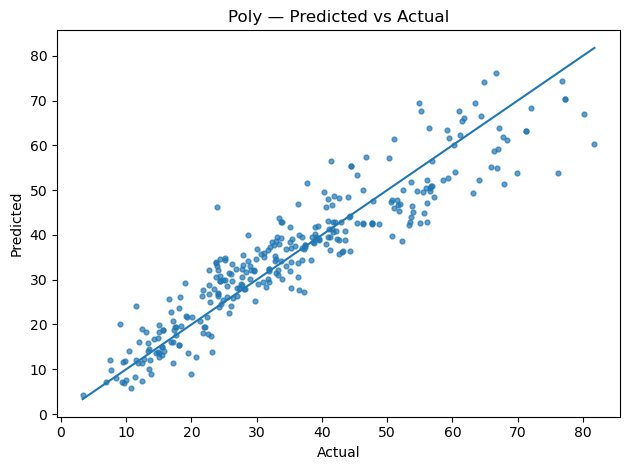

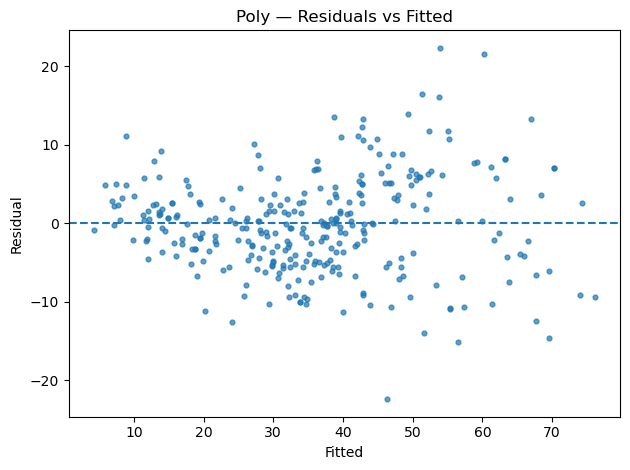

In [22]:
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'reports', 'figures')
plot_pred_vs_actual(y_test, y_pred_test, title='Poly — Predicted vs Actual', save_path=os.path.join(fig_dir, 'poly_pv.png'))
plot_residuals(y_test, y_pred_test, title='Poly — Residuals vs Fitted', save_path=os.path.join(fig_dir, 'poly_resid.png'))

In [28]:
best_model = gcv.best_estimator_
poly = best_model.named_steps['poly']
feature_names = poly.get_feature_names_out(X_train.columns)

linreg = best_model.named_steps['est']
coefs = linreg.coef_
intercept = linreg.intercept_
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values(by="coefficient", key=abs, ascending=False)

print("Intercept:", intercept)
display(coef_df.head(20))

Intercept: 39.518579085026


,feature,coefficient
0,cement,15.617367
1,blast_furnace_slag,11.147870
7,age_log,10.160952
11,cement water,-9.189196
32,water fine_aggregate,-8.436681
14,cement fine_aggregate,-7.303285
31,water coarse_aggregate,-5.921497
2,fly_ash,5.779922
24,fly_ash water,-5.614015
18,blast_furnace_slag water,-5.374165
